<a href="https://colab.research.google.com/github/mpgdv/20242R0136COSE47402/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Understanding DETR model

In [1]:
from torch import nn

class DETR(nn.Module):
  def __init__(self, num_classes, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, num_queries=100):
    super().__init__()

    #create ResNet-50 backbone
    self.backbone = resnet50()
    del self.backbone.fc

    #create conversion layer
    self.conv = nn.Conv2d(2048, hidden_dim, 1)

    #create a default Pytorch transformer
    self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers,num_decoder_layers)

    #prediction heads, one extra class for predicting non-empty slots
    #note that in baseline DETR linear__bbox layer is 3-layer MLP
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
    self.linear_bbox = nn.Linear(hidden_dim, 4)

    #output positional encodings (object queries)
    self.query_pos = nn.Parameter(torch.rand(100 ,hidden_dim))


    #spatial positional encodings
    #note that in baseline DETR we use sine positional encodings
    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

  def forward(self, inputs):
    #propagate inputs through ResNet-50 up to avg-pool layer
    x = self.backbone.conv1(inputs)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x =  self.backbone.layer1(x)
    x =  self.backbone.layer2(x)
    x =  self.backbone.layer3(x)
    x =  self.backbone.layer4(x)

    #convert from 2048 to 256 feature planes for the transformer
    h = self.conv(x)

    #construct positional encoding
    H, W = h.shape[-2:]
    pos = torch.cat([
        self.col_embed[:W].unsqueeze(0).repeat(H,1,1),
        self.row_embed[:H].unsqueeze(1).repeat(1,W,1),
    ], dim=-1).flatten(0,1).unsqueeze(1)

    #propagate through the transformer
    h = self.transformer(pos + 0.1 * h.flatten(2).permute(2,0,1), self.query_pos.unsqueeze(1)).transpose(0,1)

    #finally project transformer outputs to class labels and bounding boxes
    pred_logits = self.linear_class(h)
    pred_boxes = self.linear_bbox(h).sigmoid()

    return {'pred_logits': pred_logits,
            'pred_boxes': pred_boxes}

# Q2. Custom Image Detection and Attention Visualization

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn

from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

#colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
  x_c, y_c, w, h = x.unbind(1)
  b = [(x_c - 0.5 * w), (y_c -0.5 * h),
       (x_c + 0.5 * w), (y_c + 0.5 * h)]
  return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
  img_w, img_h = size
  b = box_cxcywh_to_xyxy(out_bbox)
  b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
  return b

def plot_results(pil_img, prob, boxes):
  plt.figure(figsize=(16,10))
  plt.imshow(pil_img)
  ax = plt.gca()
  colors = COLORS * 100

  for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
    ax. add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
    cl = p.argmax()
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

  plt.axis('off')
  plt.show()

Load a model from hub, run it on a custom image, and print the result.

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


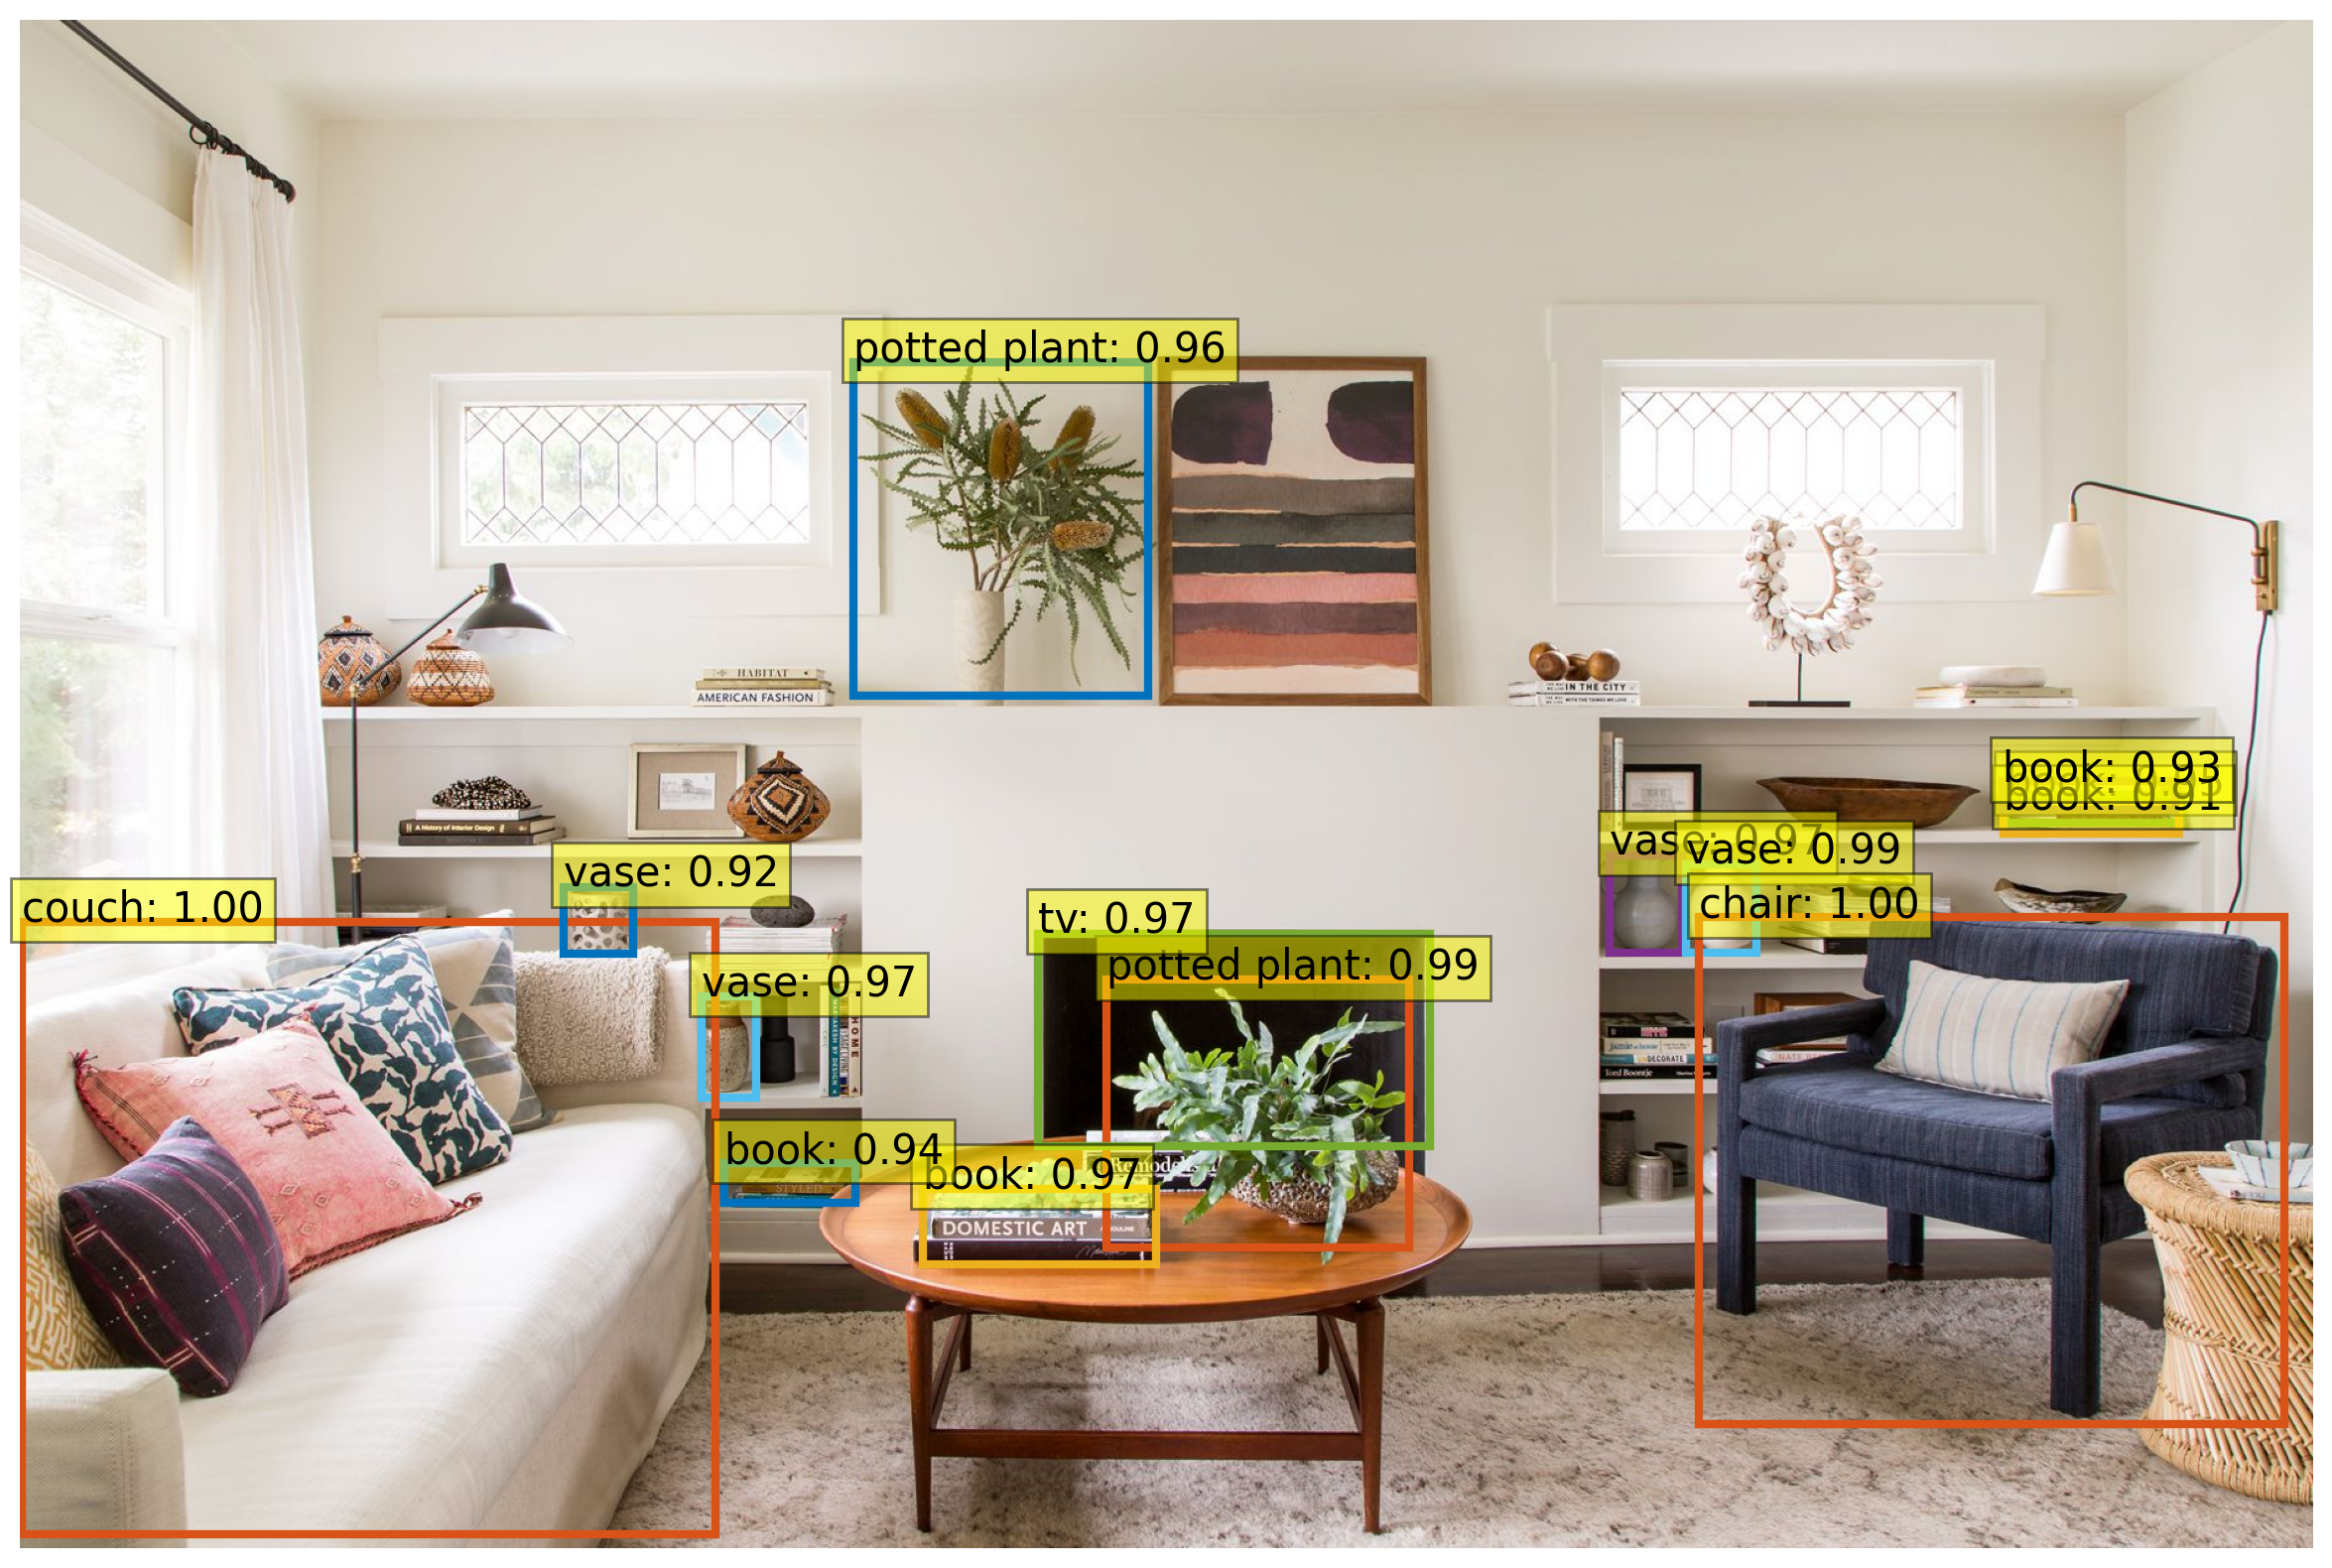

In [10]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

url = 'https://www.bhg.com/thmb/EmuKL4yiqCMRZlclvSIJtMln9vU=/1866x0/filters:no_upscale():strip_icc()/renovated-neutral-colored-living-room-2f194807-3856ba1a2ea04e269ea42e93021fda64.jpg'
im = Image.open(requests.get(url, stream=True).raw)#put your own image--------------

#mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

#propagate through the model
outputs = model(img)

#keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

#convert boxes from [0;1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

#mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

#propagate through the model
outputs = model(img)

#keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

#convert boxes from [0;1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

#mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

#propagate through the model
outputs = model(img)

#keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

#convert boxes from [0;1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)



Visualize attention weights of the last decoder layer.

In [11]:
#use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(lambda self, input, output: conv_features.append(output)),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(lambda self, input, output: enc_attn_weights.append(output[1])),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(lambda self, input, output: dec_attn_weights.append(output[1])),
]

#propagate through the model
outputs = model(img)#put your own image

for hook in hooks:
  hook.remove()

#don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

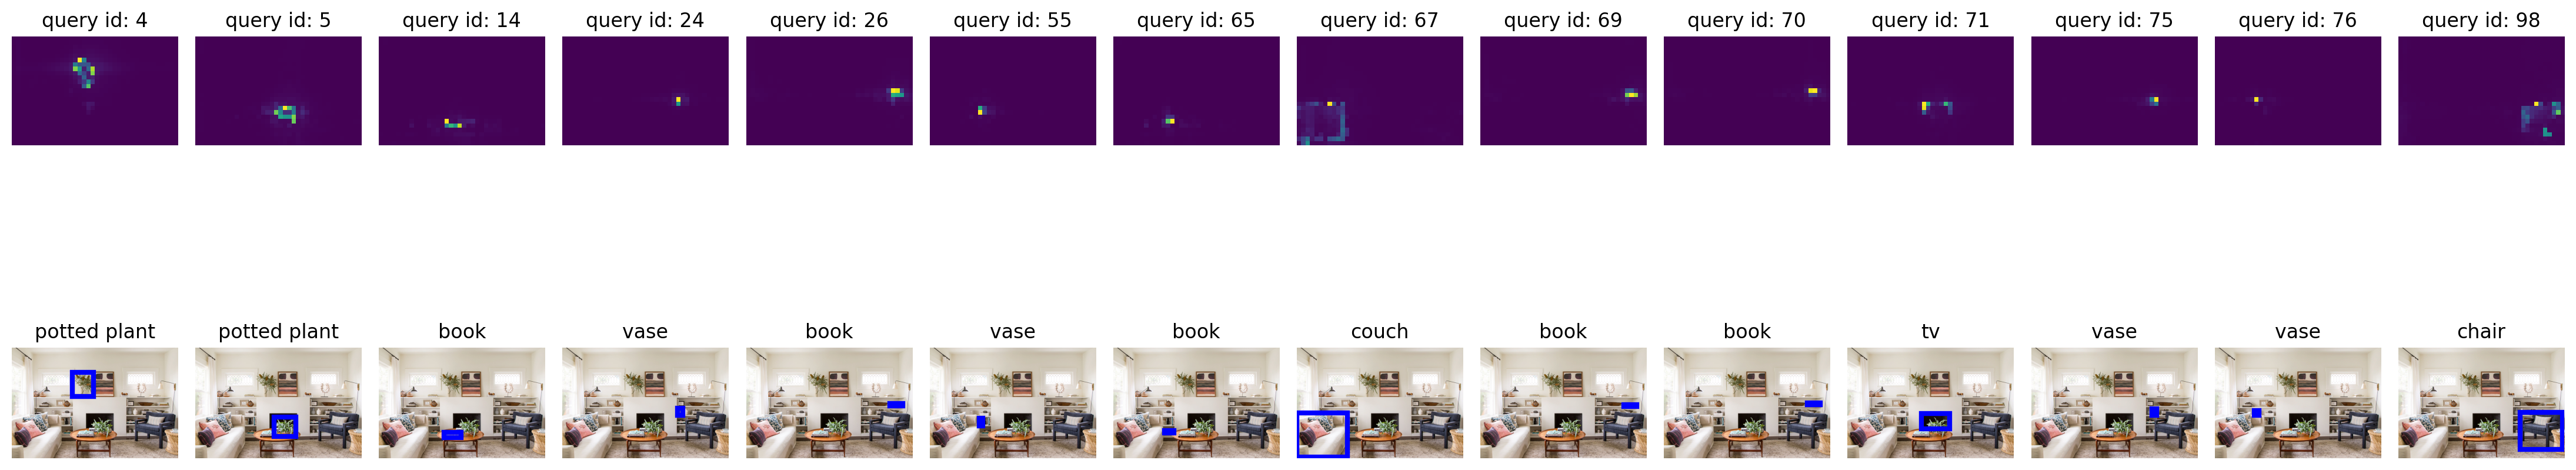

In [12]:
#get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22,7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
  ax = ax_i[0]
  ax.imshow(dec_attn_weights[0, idx].view(h,w))
  ax.axis('off')
  ax.set_title(f'query id: {idx.item()}')
  ax = ax_i[1]
  ax.imshow(im)
  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='blue', linewidth=3))
  ax.axis('off')
  ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

Visualize how the decoder's query attends  to specific areas corresponding to the detected objects

In [13]:
#output of the CNN
f_map = conv_features['0']
print("Encoder attention:   ", enc_attn_weights[0].shape)
print("Feature map:         ", f_map.tensors.shape)

Encoder attention:    torch.Size([950, 950])
Feature map:          torch.Size([1, 2048, 25, 38])


In [15]:
#get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
#and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention: ", sattn.shape)

Reshaped self-attention:  torch.Size([25, 38, 25, 38])


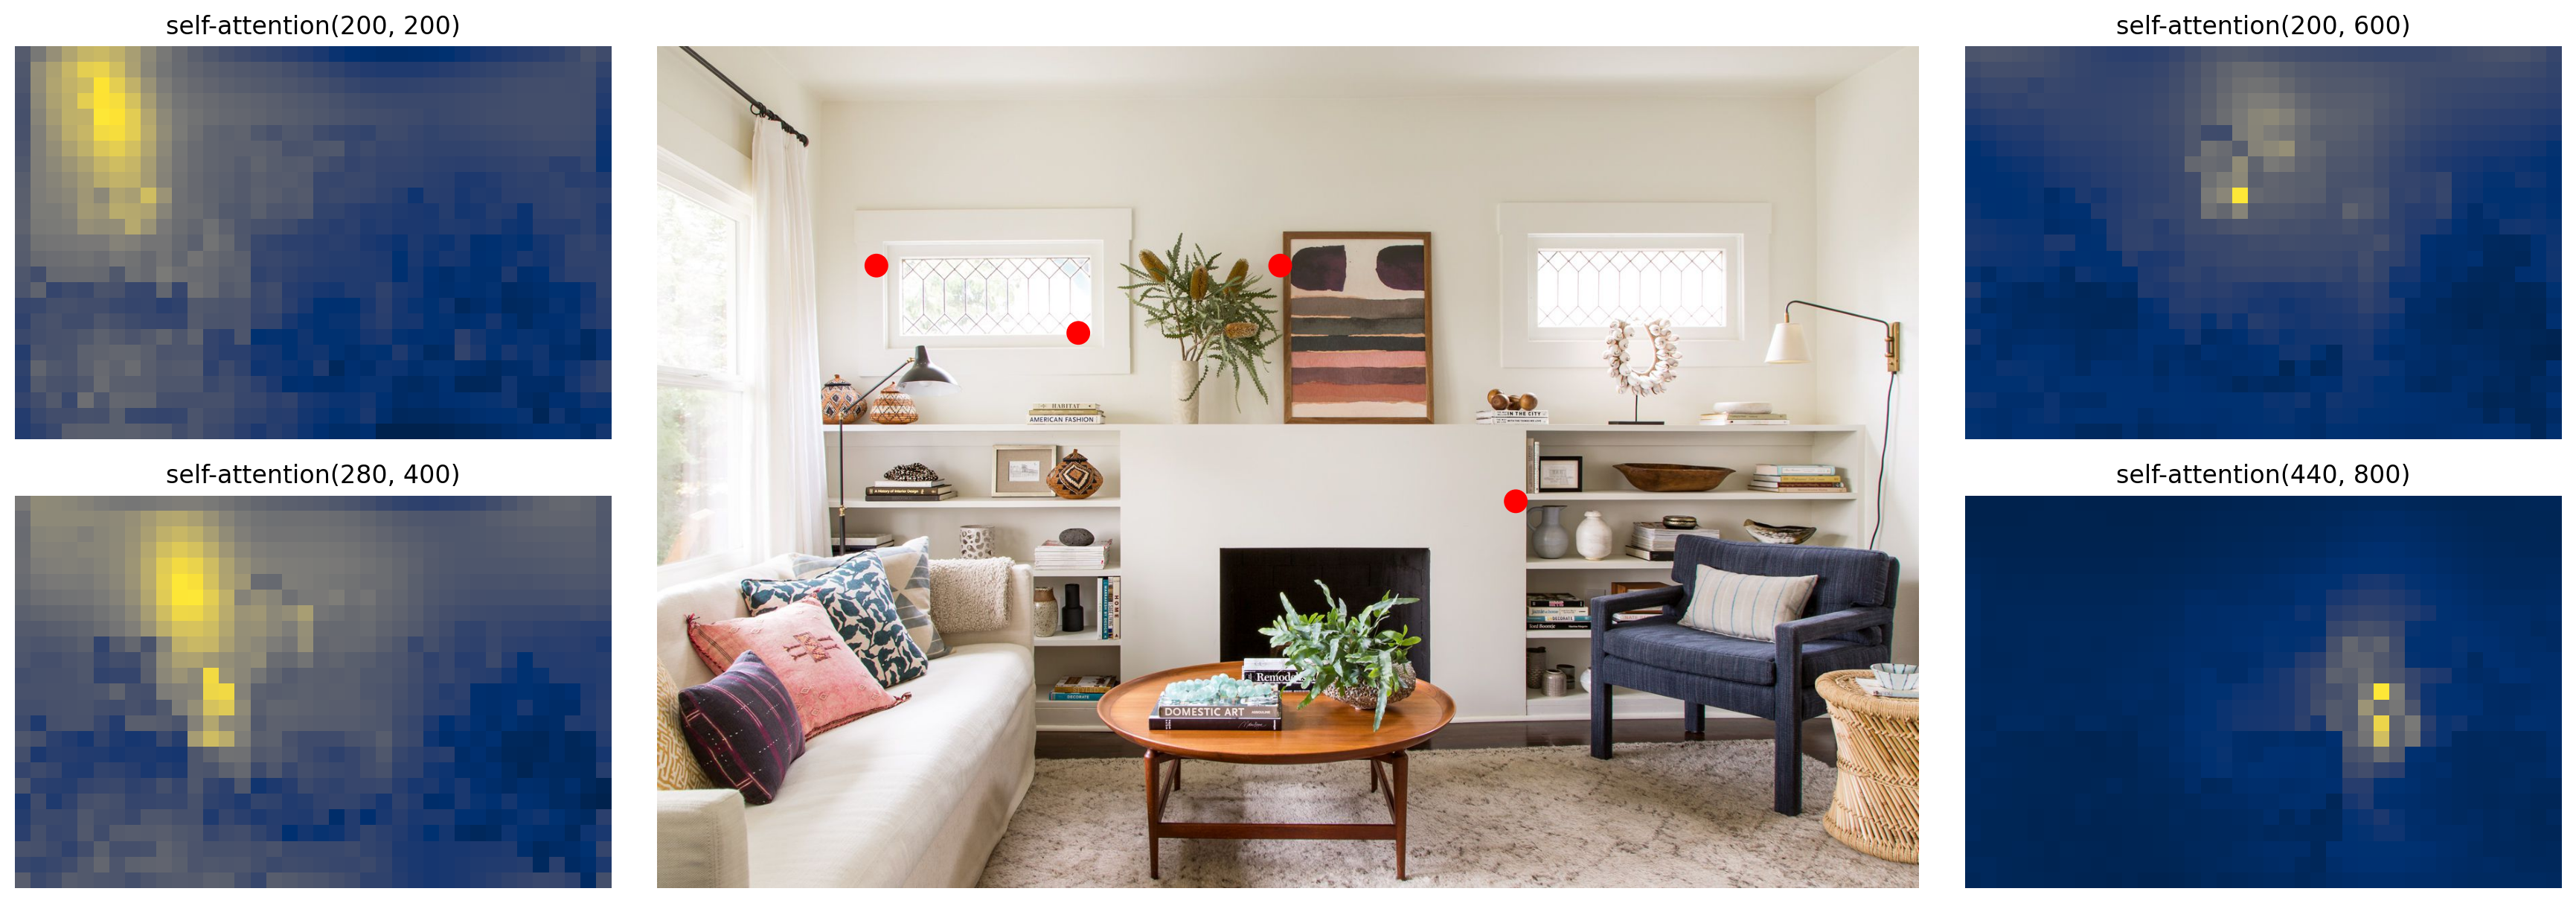

In [16]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

# Q3 Understanding Attention Mechanisms

* Briefly describe the types of attention used in the encoder and decoder, and explain the key differences between them.
  - Self-attention: allows the model to focus on different parts of the input sequence when processing each element.his one is used in the Encoder and decoder. In the encoder, each position in the image feature map attends to every other position within the same feature map. This allows all spatial positions to interact and capture global information across the image. The decoder applies the self-attention on the object queries. Each query attends to all the other queries, allowing them to share context among themselves.
  - Cross-attention: This is only used in the decoder and enables each query in the decoder to attend to the encoder's output feature map. This allows each object query to attend to relevant parts of the encoded image features, aligning each query with specific regions in the image.

  - Key differences:
    - Self-attention:
      - operates on a single input sequence.
      - is used to capture relationships and dependenceies within the same input sequence.
    - Cross-attention:
      - operates on two different input sequences: a source sequence and a target sequence
      - allows the model to focus on different parts of the source sequence when generating each element of the target sequence.

* Based on the visualized results from Q2, provide an analysis of the distinct characteristics of each attention mechanism in the encoder and decoder. Feel free to express your insights.
  - In the first image, the decoder attention maps correspond to specific queries (objects or classes). Each attention map here shows the attention for a differente query, providing insight into how the decoder isolates individual objects in the scene.
    - Each column represents attention for a particular query, it focuses on the region which the query is located. This shows that the decoder's attention is object-specific and query-driven, enabling it to focuse on relevant parts of the image bsaed on the class it is predicting.
    - The attention maps in the decoder have more defined boundaries around the objects. This is visible in how the attention for each query isolates its target more precisely. This characteristic is due to the decoder's need to separate individual objects from the background.
    - There is minimal overlap between the objects attended to in different queries. This separation suggests that the decoder has learned to differentiate between objects spatially, ensuring that each query's attention map is distinct and does not interfere with others. This helps to have a clear distinction between the different items on the image.
  - In the second image are the attention maps from the encoder, showing self-attention focused on specific spatial regions within the input image.
    - Each enconder attention map highlights how different regions in the image "attend" to especific spatial areas. The attention is more spread out, with activations around broader regions, reflecting the encoder's role in capturing spatial context around each pixel. This ensures that each pixel representation incorporates information from surrounding areas.
    - For the red points, the attention maps show activations that extend to nearby regions. This indicates that the encoder is learning spatial relationships and contextual information, helping it distinguish between objects and their surroundings.
    - Each encoder attention map has a somewhat symmetrical pattern, suggesting that the encoder is building a global understanding by focusing equally on different areas. This creates feature representations that capture the scene broadly, without being tied to any specific object query.